# Homework 7: Sentiment Classification with Pre-trained and Re-trained GloVe Embeddings

In this notebook, we continue our investigation of text classification using “Bag of Embeddings” models and the IMDB movie review dataset.

Previously, we used pre-trained GloVe embeddings as fixed feature extractors. In this homework, we move to **fine-tuning** those embeddings — allowing gradient updates to adapt the embedding space to the sentiment classification task.

You will explore how model performance is affected by:

- Fine-tuning vs. frozen embeddings  
- Architectural adjustments  
- Vocabulary size and maximum message length  
- Embedding dimensionality  

You'll complete three problems:

- **Problem One:** Build a baseline model with unfrozen embeddings and experiment with architectural and training adjustments to improve performance.
- **Problem Two:** Investigate how increasing the maximum message length and vocabulary size affects model accuracy and generalization.
- **Problem Three:** Examine the impact of changing the embedding dimension on model performance.

In each problem, you will report your best validation accuracy and reflect on what your experiments reveal about model capacity, generalization, and diminishing returns.

### Useful Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
from datetime import datetime
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


# -----------------------------
# Reproducibility
# -----------------------------
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# -----------------------------
# Utility: format elapsed time
# -----------------------------
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example usage:
# start_time = time.time()
# <your code>
# print("Execution Time:", format_hms(time.time() - start_time))

# Suppress TensorFlow INFO/WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## GloVe Setup (Auto-Download if Needed)

This notebook will automatically download the GloVe 6B embeddings
if they are not already present (you should have them if you ran the Coding Notebook from Week 7). 

In [2]:
import os, zipfile, urllib.request
from pathlib import Path
import numpy as np
from tensorflow.keras.datasets import imdb

# -----------------------------
# GloVe Setup (auto-download)
# -----------------------------
GLOVE_DIR = Path(os.environ.get("GLOVE_DIR", "data/glove")).expanduser()
GLOVE_DIR.mkdir(parents=True, exist_ok=True)

GLOVE_6B_URL = "https://nlp.stanford.edu/data/glove.6B.zip"

def ensure_glove_6b(download_dir: Path) -> Path:
    zip_path = download_dir / "glove.6B.zip"
    extracted_dir = download_dir / "glove.6B"

    if extracted_dir.exists() and any(extracted_dir.glob("glove.6B.*d.txt")):
        return extracted_dir

    if not zip_path.exists():
        print(f"Downloading GloVe 6B to: {zip_path}")
        urllib.request.urlretrieve(GLOVE_6B_URL, zip_path)

    print(f"Extracting: {zip_path} -> {download_dir}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(download_dir)

    if extracted_dir.exists():
        return extracted_dir
    if any(download_dir.glob("glove.6B.*d.txt")):
        return download_dir

    raise FileNotFoundError("GloVe files not found after extraction.")

def load_glove_vectors(glove_folder: Path, embedding_dimension: int) -> dict:
    glove_path = glove_folder / f"glove.6B.{embedding_dimension}d.txt"
    if not glove_path.exists():
        raise FileNotFoundError(
            f"Missing {glove_path}. Re-run the setup cell or check your GLOVE_DIR."
        )

    embeddings_index = {}
    with glove_path.open(encoding="utf8") as f:
        for line in f:
            word, *vec = line.split()
            embeddings_index[word] = np.asarray(vec, dtype="float32")
    return embeddings_index

def build_embedding_matrix(training_vocabulary_size: int, embedding_dimension: int) -> np.ndarray:
    glove_folder = ensure_glove_6b(GLOVE_DIR)
    embeddings_index = load_glove_vectors(glove_folder, embedding_dimension)

    word_index = imdb.get_word_index()
    embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension), dtype="float32")

    for word, raw_idx in word_index.items():
        idx = raw_idx + 3
        if idx >= training_vocabulary_size:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

    return embedding_matrix

GLOVE_FOLDER = ensure_glove_6b(GLOVE_DIR)
print(f"GloVe folder ready: {GLOVE_FOLDER}")

Extracting: data/glove/glove.6B.zip -> data/glove
GloVe folder ready: data/glove


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far
- We've also added  `

In [3]:
def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task. 
- Assumes `X_train,y_train,X_test,y_test` already defined, will access them as global variables. 
- If `X_val` and `y_val` defined, will use those, else assumes `validation_split = 0.2` in `fit`


**Note:** See the end of the notebook for results and parameter settings. 

In [4]:
def train_and_test(model, 
                   title         = "Learning Curves",
                   epochs        = 200,                   # Just needs to be bigger than early stopping point
                   optimizer     = "Adam",
                   lr_schedule   = 1e-3,                  # Adam defaults 
                   clipnorm      = None,                 
                   batch_size    = 128,  
                   loss          = "binary_crossentropy",
                   metrics       = ["accuracy"],
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule,clipnorm=clipnorm) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer = opt, 
                  loss      = loss, 
                  metrics   = metrics
                 )

  

    if use_early_stopping:
        early_stop = EarlyStopping(
            monitor              = 'val_loss',
            patience             = patience,
            min_delta            = min_delta,
            restore_best_weights = True,               # this will mean that the model which produced the smallest validation loss will be returned
            verbose              = verbose
        ) 
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    # If X_val defined, then  use it, else assume val is split from train

    if 'X_val' in globals():
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),      
                            callbacks=cbs,
                            verbose=verbose
                           )
    else:
        history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.2,      
                            callbacks=cbs,
                            verbose=verbose
                           )        

    # Plot training history
    plot_learning_curves(history, title=title)

    # Find epoch with minimum validation loss
    min_val_epoch = np.argmin(history.history['val_loss'])
    # Retrieve the values at that epoch
    min_val_loss = history.history['val_loss'][min_val_epoch]    
    # Get corresponding validation accuracy at that epoch
    val_acc_at_min_loss = history.history['val_accuracy'][min_val_epoch]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    # Print out results

    print(f"\nFinal Training Loss:            {history.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy:        {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss:          {history.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy:      {history.history['val_accuracy'][-1]:.4f}")
    print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
    print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Accuracy Gap: {abs(val_acc_at_min_loss - test_accuracy):.6f}")

    # Store accuracy in results
    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

    # Store all information about run in parameter_settings
    
    global parameter_settings
    entry = {
        "title": title,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "epochs": int(epochs),
        "optimizer": optimizer,
        "lr_schedule": lr_schedule,
        "clipnorm": clipnorm,
        "loss": loss,
        "batch_size": batch_size,
        "use_early_stopping": use_early_stopping,
        "patience": patience,
        "min_delta": min_delta,
        "callbacks": _summarize_callbacks(callbacks),
        "Final Training Loss" : history.history['loss'][-1],
        "Final Training Accuracy" : history.history['accuracy'][-1],
        "Final Val Loss" : history.history['val_loss'][-1],
        "Final Val Accuracy" : history.history['val_accuracy'][-1],
        "Min Val Loss" : min_val_loss,
        "Min Val Loss Epoch" : min_val_epoch,
        "Val Acc @ Min Loss" : val_acc_at_min_loss,
        "Test Loss" : test_loss,
        "Test Acc" : test_accuracy,
        "Val-Test Accuracy Gap:" : abs(val_acc_at_min_loss - test_accuracy)
    }
    parameter_settings.setdefault(title, []).append(entry)  

    if return_history:
        return history

def _summarize_callbacks(cbs):
    if cbs is None:
        return None
    out = []
    for cb in cbs:
        name = getattr(cb, "__class__", type(cb)).__name__
        info = {"class": name}
        # grab a few common attributes if present
        for attr in ("monitor", "mode", "patience", "min_delta",
                     "factor", "min_lr", "verbose", "cooldown"):
            if hasattr(cb, attr):
                info[attr] = getattr(cb, attr)
        out.append(info)
    return out

results = {}
parameter_settings = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-5,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

#  put in the callbacks list:

#    train_and_test(model, title="Learning Curves",callbacks=[reduce_lr])


### Prelude:  A little EDA: Distribution of review lengths and coverage by max vocabulary size

You will use this to think about where the set parameters for maximum review length and the maximum number of unique tokens to use. 


Total unique words in Keras IMDB word_index (corpus-wide): 88,584
Num training reviews: 25,000
Max length: 2,494 tokens
Mean length: 238.7 tokens
Median length: 178 tokens
90th percentile: 467 tokens
95th percentile: 610 tokens
99th percentile: 926 tokens


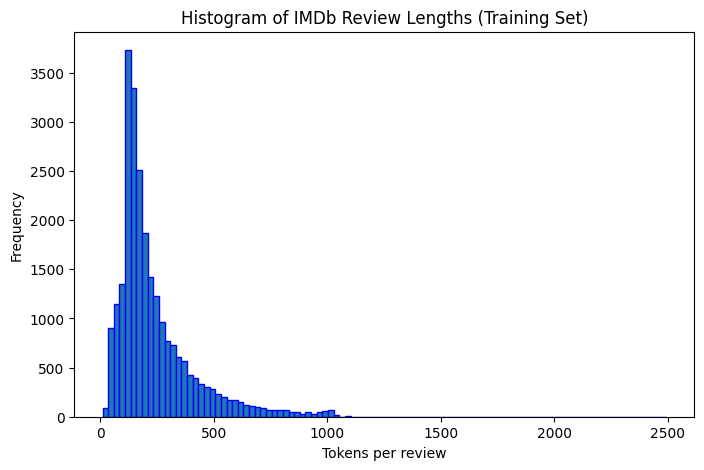


Unique word types in TRAIN (id >= 3): 88,583
Total word tokens in TRAIN (id >= 3): 5,942,840

Coverage metrics by candidate vocab size (TRAIN split):
training_vocabulary_size= 2,000 | coverage= 82.84% | OOV= 17.16% | types kept=  1,997 | tokens kept= 4,922,766
training_vocabulary_size= 5,000 | coverage= 90.03% | OOV=  9.97% | types kept=  4,997 | tokens kept= 5,350,551
training_vocabulary_size=10,000 | coverage= 94.25% | OOV=  5.75% | types kept=  9,997 | tokens kept= 5,601,261
training_vocabulary_size=20,000 | coverage= 97.22% | OOV=  2.78% | types kept= 19,997 | tokens kept= 5,777,376
training_vocabulary_size=30,000 | coverage= 98.37% | OOV=  1.63% | types kept= 29,997 | tokens kept= 5,846,141
training_vocabulary_size=50,000 | coverage= 99.32% | OOV=  0.68% | types kept= 49,997 | tokens kept= 5,902,246
training_vocabulary_size=70,000 | coverage= 99.69% | OOV=  0.31% | types kept= 69,997 | tokens kept= 5,924,254
training_vocabulary_size=88,584 | coverage=100.00% | OOV=  0.00% | types

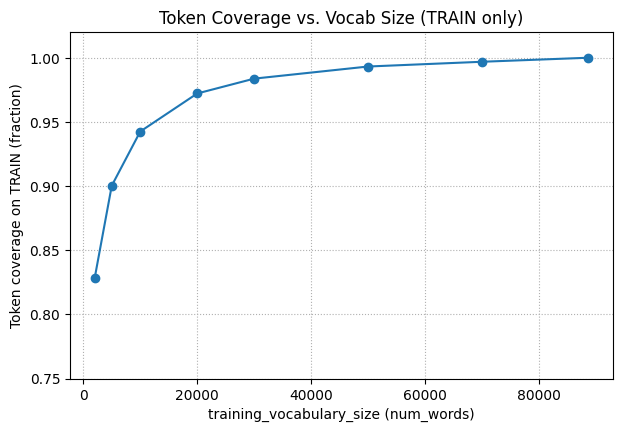

In [6]:
# IMDB vocab & length stats + coverage table + single coverage plot

from tensorflow.keras.datasets import imdb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# Load IMDB with NO cap (so we can measure coverage fairly)
# ---------------------------------------
(X_tr, y_tr), _ = imdb.load_data()

# ---------------------------------------
# 1) Global vocab stats (from Keras word_index)
# ---------------------------------------
imdb_word_index = imdb.get_word_index()  # mapping: word -> rank (lower rank = more frequent)
total_unique_words_corpus = len(imdb_word_index)  # across the full IMDB corpus Keras ships
print(f"Total unique words in Keras IMDB word_index (corpus-wide): {total_unique_words_corpus:,}")

# ---------------------------------------
# 2) Training review length stats + histogram (students pick max_text_length)
# ---------------------------------------
lengths = np.fromiter((len(r) for r in X_tr), dtype=np.int32)
print(f"Num training reviews: {len(lengths):,}")
print(f"Max length: {lengths.max():,} tokens")
print(f"Mean length: {lengths.mean():.1f} tokens")
print(f"Median length: {np.median(lengths):.0f} tokens")
for q in (90, 95, 99):
    print(f"{q}th percentile: {int(np.percentile(lengths, q))} tokens")

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=100, edgecolor='b')
plt.title("Histogram of IMDb Review Lengths (Training Set)")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------
# 3) Training-only frequency counts for real words (ids >= 3)
#    IMDB ID conventions: 0=<PAD>, 1=<START>, 2=<OOV>, >=3 actual words
# ---------------------------------------
def iter_tokens(seqs):
    for s in seqs:
        for t in s:
            yield t

train_counts = Counter(t for t in iter_tokens(X_tr) if t >= 3)

# Frequency list (descending) and cumulative token coverage
freqs = np.array(sorted(train_counts.values(), reverse=True), dtype=np.int64)
cum_tokens = np.cumsum(freqs)
total_tokens_train_words = int(cum_tokens[-1])
num_unique_words_train = int(len(freqs))

print(f"\nUnique word types in TRAIN (id >= 3): {num_unique_words_train:,}")
print(f"Total word tokens in TRAIN (id >= 3): {total_tokens_train_words:,}")

# ---------------------------------------
# 4) Coverage helper for a given num_words cap (Keras convention)
#    Valid word ids are [3, num_words_cap-1] → ranks [1 .. num_words_cap-3]
# ---------------------------------------
def coverage_for_cap(num_words_cap: int):
    kept_types = max(0, min(num_words_cap - 3, num_unique_words_train))
    kept_tokens = int(cum_tokens[kept_types - 1]) if kept_types > 0 else 0
    oov_tokens = total_tokens_train_words - kept_tokens
    coverage = kept_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    oov_share = oov_tokens / total_tokens_train_words if total_tokens_train_words > 0 else 0.0
    return dict(
        cap=num_words_cap,
        kept_tokens=kept_tokens,
        kept_types=kept_types,
        coverage=coverage,
        oov_share=oov_share
    )

# ---------------------------------------
# 5) Candidate vocab sizes: ASCII table + single coverage plot
# ---------------------------------------
candidate_caps = [2_000, 5_000, 10_000, 20_000, 30_000, 50_000,70_000,88_584]  # students can edit
rows = [coverage_for_cap(k) for k in candidate_caps]

print("\nCoverage metrics by candidate vocab size (TRAIN split):")
for r in rows:
    print(f"training_vocabulary_size={r['cap']:>6,} | coverage={r['coverage']*100:6.2f}% | "
          f"OOV={r['oov_share']*100:6.2f}% | types kept={r['kept_types']:>7,} | tokens kept={r['kept_tokens']:>10,}")

plt.figure(figsize=(7, 4.5))
plt.plot(candidate_caps, [r['coverage'] for r in rows], marker='o')
plt.xlabel("training_vocabulary_size (num_words)")
plt.ylabel("Token coverage on TRAIN (fraction)")
plt.title("Token Coverage vs. Vocab Size (TRAIN only)")
plt.grid(True, linestyle=":")
plt.ylim(0.75, 1.02)
plt.show()


### Load and preprocess dataset

Here is where you can set the
- `training_vocabulary_size` and
- `max_text_length`

**Note:** This dataset downloads with a 50/50 train/test split. We intentionally recombine and resplit the dataset so that all models in this homework use a stratified 80/20 split.

In [7]:
# Load and preprocess dataset into padded sequences of token IDs

training_vocabulary_size = 50_000               # <-----
max_text_length          = 500                  # <-----

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )     

X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)



X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,             
    padding='post',     
    truncating='post'   
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)


X_train.shape,X_test.shape

((40000, 500), (10000, 500))

### Build the embedding matrix

Here is where you can set
- `embedding_dimension`


In [8]:
# Build embedding matrix
# (Re-run this cell whenever you change training_vocabulary_size
#  or embedding_dimension.)

embedding_dimension = 100   # change in Problem Three

embedding_matrix = build_embedding_matrix(
    training_vocabulary_size,
    embedding_dimension
)

print("embedding_matrix:", embedding_matrix.shape)

Extracting: data/glove/glove.6B.zip -> data/glove
embedding_matrix: (50000, 100)


### Baseline Model from the Coding Notebook


model_baseline (frozen)



I0000 00:00:1772303659.026662 6593370 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1772303659.026746 6593370 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


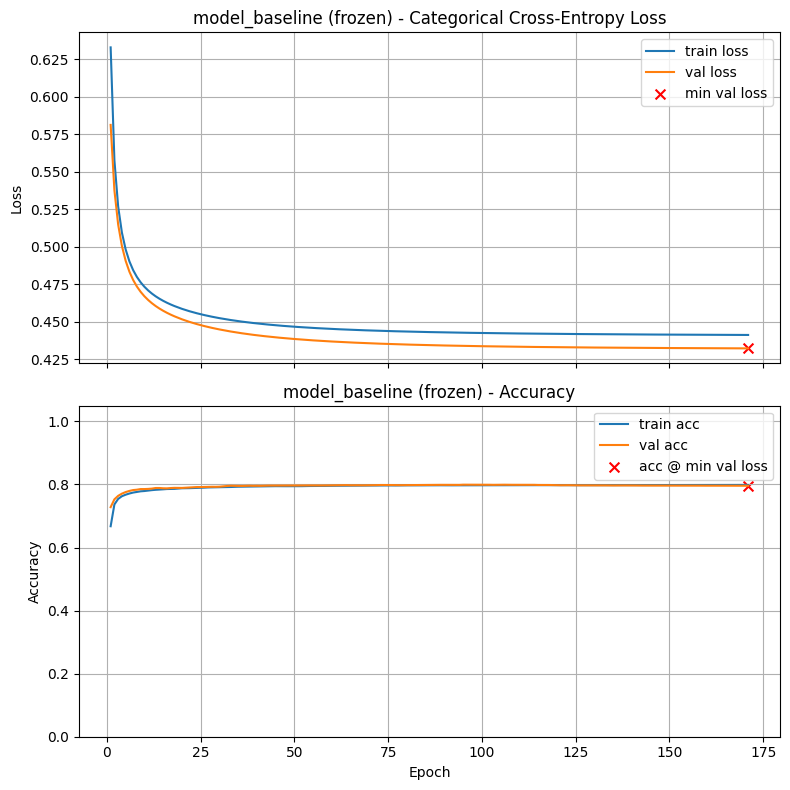


Execution Time: 00:02:42

Final Training Loss:            0.4411
Final Training Accuracy:        0.7984
Final Validation Loss:          0.4321
Final Validation Accuracy:      0.7959
Minimum Validation Loss:        0.4321 (Epoch 171)
Validation Accuracy @ Min Loss: 0.7959

Test Loss: 0.4331
Test Accuracy: 0.8076

Validation-Test Accuracy Gap: 0.011725


In [9]:

model_baseline_frozen = Sequential([
    Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
    Embedding(
        input_dim  = training_vocabulary_size,  
        output_dim = embedding_dimension,      
        weights    = [embedding_matrix],
        mask_zero  = True,                      # ignore <PAD> in pooling -- this makes a huge difference in training speed!
        trainable  = False                      # freeze or unfreeze embedding weights
    ),
    GlobalAveragePooling1D(),                        # take average along each dimension
    Dense(1, activation='sigmoid')
])
    

train_and_test(model_baseline_frozen,  lr_schedule=1e-2, title="model_baseline (frozen)")

#### End of Template Code from Coding Notebook

## Problem One: Baseline with Unfrozen Embeddings

**ToDo:**

1. Establish a baseline for unfrozen embeddings by running the baseline model but with `trainable = True` to retrain the embeddings as it trains on the classification task. 
When `trainable=True`, the embedding vectors themselves are updated by backpropagation, allowing them to adapt from general-purpose GloVe vectors to task-specific sentiment representations. You will use retrainable embeddings throughout the homework.

2. Now run 2-3 experiments to try to improve this baseline: 

    - Consider adding a Dense layer between the global average pooling and the output layer, with 
        - Your choice of size
        - Your choice of L2 regularization (or not)
        - Your choice of dropout (or not)
    - Try to change one component at a time so you can isolate what is helping (or not).
3. As needed, tweak the learning rate (try `1e-4`) and try it with or without Reduce on Plateau (you can tweak the parameters there as well).
4. Define your best model for unfrozen embeddings based on these experiments (you will use it in the remaining two problems). Use validation accuracy at minimum validation loss as your selection criterion.
5. Answer the graded questions.

**Note:** The baseline frozen model used `1e-2`. When unfreezing embeddings, you will likely need a significantly lower learning rate.

In [10]:
# Your code here; add as many cells as you need



### Graded Questions

#### Question a1a:

In [11]:
# Set a1a to the validation accuracy for your best model found in this problem

a1a = 0.0             # Replace 0.0 with your answer

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}') 

a1a = 0.0000


#### Question a1b: Describe below your experiments. What worked and what didn't?    

#### Your Answer Here:

## Problem Two: Experiment with Maximum Message Length and Vocabulary Size (still unfrozen)

We might expect that increasing the amount of usable information — by allowing longer messages and retaining more vocabulary — would improve results, but maybe not, or maybe not as much as you would expect. Let's find out!

**ToDo:**

1. Start with your best model from Problem One

2. Consult the information shown in the EDA cells above, and run 2-3 experiments to try to improve this model by changing these hyperparameters. Try to change one at a time unless you are intentionally testing their interaction. Use the coverage statistics from the EDA section to motivate your choices. Keep embedding_dimension fixed at 100 for this problem.

    - `max_text_length`, and
    - `training_vocabulary_size`

3. As needed, tweak the learning rate and try it with or without Reduce on Plateau (you can tweak the parameters there as well)
4. Define your best model for use in Problem Three
5. Answer the graded questions

**Notes:**

>  Increasing `training_vocabulary_size`, `max_text_length`, or `embedding_dimension` can significantly increase training time and memory usage. You are not expected to try all combinations. Instead, choose 2–3 well-motivated experiments. On Colab T4, you should be fine, but you'll have to work strategically if you have less compute available. 


> `train_and_test` accesses the training and testing files as globals. You can cut and paste copies of the cells which load, preprocess, and build the embeddings for the dataset, 
but you'll be **redefining the global names,** just be careful about the order in which you run cells. As an alternative, you can change the parameters in the code in the Prelude, and
just run this problem here. 

In [13]:
# Your code here; add as many cells as you need



### Graded Questions

In [14]:
# Set a2a to the validation accuracy for your best model found in this problem

a2a = 0.0             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.4f}') 

a2a = 0.0000


#### Question a2b: Describe below your experiments. What effect did your changes to the dataset have? Did it help as you as you expected?   

#### Your Answer Here:

## Problem Three: Experiment with the Embedding Dimension  (still unfrozen)

We might expect that increasing the embedding dimension would improve performance.  
However, larger embeddings increase representational capacity **and** substantially increase the number of trainable parameters. Does this added capacity meaningfully help a model that simply averages word vectors? Let’s find out.

**ToDo:**

1. Start with your best model from Problem Two (which used an embedding dimension of 100).
2. Increase the embedding dimension to 300 and observe the effect. (Optional: Try 50 and 200 as well.)
3. Keep all other settings fixed. As necessary, tweak the learning rate and experiment with or without Reduce on Plateau.
4. Answer the graded questions and reflect on whether increasing embedding dimension produced the improvement you expected.

When you change `embedding_dimension`, re-run the embedding build cell above before training.

In [16]:
# Your code here; add as many cells as you need

### Graded Questions

In [17]:
# Set a3a to the validation accuracy for your best model found in this problem

a3a = 0.0             # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0000


#### Question a3b: Describe below your experiments. What effect did increasing the dimension from 100 to 300 have? Did it help as you as you expected?  

#### Your Answer Here:

In [19]:
print_results()

model_baseline (frozen)                 	0.7959	171


In [20]:
# This will have recorded details of all your experiments

parameter_settings

{'model_baseline (frozen)': [{'title': 'model_baseline (frozen)',
   'timestamp': '2026-02-28T13:37:01',
   'epochs': 200,
   'optimizer': 'Adam',
   'lr_schedule': 0.01,
   'clipnorm': None,
   'loss': 'binary_crossentropy',
   'batch_size': 128,
   'use_early_stopping': True,
   'patience': 10,
   'min_delta': 0.0001,
   'callbacks': [],
   'Final Training Loss': 0.4410663843154907,
   'Final Training Accuracy': 0.7984374761581421,
   'Final Val Loss': 0.4321042001247406,
   'Final Val Accuracy': 0.7958750128746033,
   'Min Val Loss': 0.4321042001247406,
   'Min Val Loss Epoch': 170,
   'Val Acc @ Min Loss': 0.7958750128746033,
   'Test Loss': 0.4330577552318573,
   'Test Acc': 0.8076000213623047,
   'Val-Test Accuracy Gap:': 0.011725008487701416}]}